In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sys

In [2]:
# Variables and functions from other files
ACCURACY_KEY = 'accuracy'
BYTES_WRITTEN_KEY = 'bytes_written'
BYTES_READ_KEY = 'bytes_read'
LOCAL_COMPUTATIONS_KEY = 'local_computations'
NUM_ROUND_KEY = 'round_number'
NUM_SAMPLES_KEY = 'num_samples'
CLIENT_ID_KEY = 'client_id'

def _weighted_mean(df, metric_name, weight_name):
    d = df[metric_name]
    w = df[weight_name]
    try:
        return (w * d).sum() / w.sum()
    except ZeroDivisionError:
        return np.nan

In [3]:
# Function to get list of test accuracy from all clients
def getLogs(directory, starts_with):
    
    all_files = []
    for file in os.listdir(directory):
        all_files.append(directory + '/' + file)
    
    selected_files = []
    for log_file in all_files:
        if log_file.startswith(starts_with):
            selected_files.append(log_file)
    
    return(selected_files)

In [4]:
# Function to summarize test accuracy on each communication round
def get_accuracy(stat_metrics_file):
    stat_metrics = pd.read_csv(stat_metrics_file) if stat_metrics_file else None
    if stat_metrics is not None:
        stat_metrics.sort_values(by=NUM_ROUND_KEY, inplace=True)

    accuracies = stat_metrics.groupby(NUM_ROUND_KEY)
    accuracies = accuracies.apply(_weighted_mean, ACCURACY_KEY, NUM_SAMPLES_KEY)

    return(accuracies)

In [5]:
# Function to create smooth version of the test accuracy trend line
def smoothMetric(metric, step):

    newMetric = []
    for index in range(0, len(metric), step):
        newMetric.append(metric[index])

    return(newMetric)

In [6]:
# Get the log files of MNIST dataset
logFiles = getLogs('mnist', 'mnist/stat')
logFiles

['mnist/stat_metrics-B-10-E-1.csv',
 'mnist/stat_metrics-B-10-E-5.csv',
 'mnist/stat_metrics-B-50-E-1.csv',
 'mnist/stat_metrics-B-50-E-5.csv',
 'mnist/stat_metrics-B-600-E-1.csv',
 'mnist/stat_metrics-B-600-E-5.csv']

In [7]:
# Get test accuracy trend of different hyperparameter settings
accuracies_B10_E1 = get_accuracy(logFiles[0]).tolist()
accuracies_B10_E5 = get_accuracy(logFiles[1]).tolist()
accuracies_B50_E1 = get_accuracy(logFiles[2]).tolist()
accuracies_B50_E5 = get_accuracy(logFiles[3]).tolist()
accuracies_B600_E1 = get_accuracy(logFiles[4]).tolist()
accuracies_B600_E5 = get_accuracy(logFiles[5]).tolist()

In [8]:
# Create smooth version of the test accuracy over communcation rounds
accuracies_B10_E1 = smoothMetric(accuracies_B10_E1, 20)
accuracies_B10_E5 = smoothMetric(accuracies_B10_E5, 20)
accuracies_B50_E1 = smoothMetric(accuracies_B50_E1, 20)
accuracies_B50_E5 = smoothMetric(accuracies_B50_E5, 20)
accuracies_B600_E1 = smoothMetric(accuracies_B600_E1, 20)
accuracies_B600_E5 = smoothMetric(accuracies_B600_E5, 20)

In [9]:
# Find total number of communcation needed to achieve the target accuracy
#next(x[0] for x in enumerate(accuracies_B600_E1) if x[1] >= 0.7) + 1
print(next(x[0] for x in enumerate(accuracies_B600_E5) if x[1] >= 0.7) + 1)
print(next(x[0] for x in enumerate(accuracies_B50_E1) if x[1] >= 0.7) + 1)
print(next(x[0] for x in enumerate(accuracies_B10_E1) if x[1] >= 0.7) + 1)
print(next(x[0] for x in enumerate(accuracies_B50_E5) if x[1] >= 0.7) + 1)
print(next(x[0] for x in enumerate(accuracies_B10_E5) if x[1] >= 0.7) + 1)

30
15
13
9
6


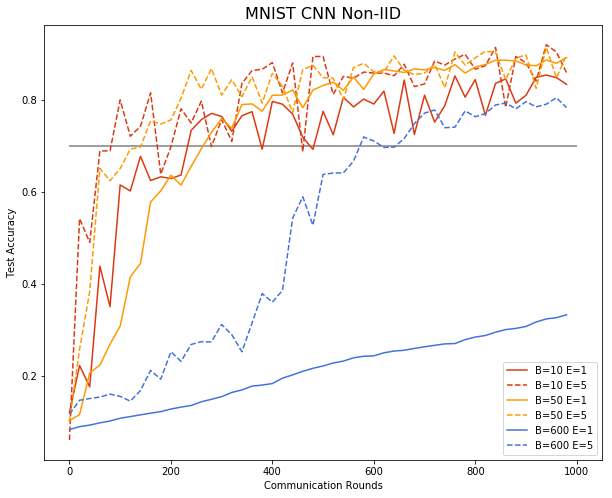

In [10]:
# Plot the test accuracy over communcation rounds
plt.figure(figsize=(10, 8))
plt.title('MNIST CNN Non-IID', fontsize=16)
plt.plot(accuracies_B10_E1, label='B=10 E=1', c='#dc3912')
plt.plot(accuracies_B10_E5, label='B=10 E=5', c='#dc3912', ls='--')
plt.plot(accuracies_B50_E1, label='B=50 E=1', c='#ff9900')
plt.plot(accuracies_B50_E5, label='B=50 E=5', c='#ff9900', ls='--')
plt.plot(accuracies_B600_E1, label='B=600 E=1', c='#4272db')
plt.plot(accuracies_B600_E5, label='B=600 E=5', c='#4272db', ls='--')
plt.hlines(0.7, 0, 50, colors='gray')
plt.xticks(np.arange(0, 51, 10), ('0', '200', '400', '600', '800', '1000'))
plt.xlabel("Communication Rounds")
plt.ylabel("Test Accuracy")
plt.legend();

In [11]:
# Get the log files of FEMNIST dataset
logFiles = getLogs('femnist', 'femnist/stat')
logFiles

['femnist/stat_metrics-B-100-E-1.csv',
 'femnist/stat_metrics-B-100-E-5.csv',
 'femnist/stat_metrics-B-50-E-1.csv',
 'femnist/stat_metrics-B-50-E-5.csv']

In [12]:
# Get test accuracy trend of different hyperparameter settings
accuracies_B100_E1 = get_accuracy(logFiles[0]).tolist()
accuracies_B100_E5 = get_accuracy(logFiles[1]).tolist()
accuracies_B50_E1 = get_accuracy(logFiles[2]).tolist()
accuracies_B50_E5 = get_accuracy(logFiles[3]).tolist()

In [13]:
# Create smooth version of the test accuracy over communcation rounds
accuracies_B100_E1 = smoothMetric(accuracies_B100_E1, 2)
accuracies_B100_E5 = smoothMetric(accuracies_B100_E5, 2)
accuracies_B50_E1 = smoothMetric(accuracies_B50_E1, 2)
accuracies_B50_E5 = smoothMetric(accuracies_B50_E5, 2)

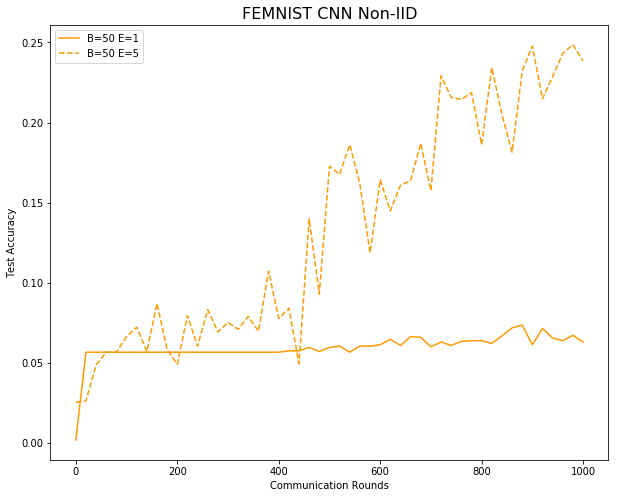

In [14]:
# Plot the test accuracy over communcation rounds
plt.figure(figsize=(10, 8))
plt.title('FEMNIST CNN Non-IID', fontsize=16)
plt.plot(accuracies_B50_E1, label='B=50 E=1', c='#ff9900')
plt.plot(accuracies_B50_E5, label='B=50 E=5', c='#ff9900', ls='--')
#plt.plot(accuracies_B100_E1, label='B=100 E=1', c='#4272db')
#plt.plot(accuracies_B100_E5, label='B=100 E=5', c='#4272db', ls='--')
plt.xticks(np.arange(0, 51, 10), ('0', '200', '400', '600', '800', '1000'))
plt.xlabel("Communication Rounds")
plt.ylabel("Test Accuracy")
plt.legend();